# Régression logistique avec descente de gradient et calcul parallèle

In [220]:
library(readxl)
library(ggplot2)
library(devtools)

In [221]:
# test avec data_breast_cancer
data <- read_excel("breast.xlsx")
data

clump,ucellsize,ucellshape,mgadhesion,sepics,bnuclei,bchromatin,normnucl,mitoses,classe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
10,6,6,2,4,10,9,7,1,malignant
4,2,2,1,2,1,2,1,1,begnin
1,1,1,1,2,1,2,1,1,begnin
2,1,1,1,2,1,2,1,1,begnin
4,1,1,1,2,1,2,1,1,begnin
1,1,1,1,2,1,1,1,1,begnin
1,1,1,1,2,1,2,1,1,begnin
5,1,1,1,2,1,2,1,1,begnin
3,1,1,1,2,1,2,1,1,begnin


In [222]:
get_x_y <- function(formula, data) {
    data_frame <- model.frame(formula, data)

    # y <- as.factor(data_frame[, 1])
    # levels(y) <- c(1, 0)
    # y <- matrix(as.integer(y))

    y <- matrix(ifelse(data_frame[, 1] == "malignant", 1, 0))


    x <- data_frame[, -1]
    x <- as.matrix(data.frame(rep(1, length(y)), x))

    return(list(target = y, features = x))
}

## Fonction sigmoide

$ \Large h(x) =  \frac{1}{1 + e^{-x} }  $  

![equation](https://latex.codecogs.com/png.latex?%5Clarge%20h%28x%29%20%3D%20%5Cfrac%7B1%7D%7B1%20&plus;%20e%5E%7B-x%7D%20%7D)

In [223]:
sigmoid <- function(x) {
    return(1 / (1 + exp(-x)))
}

## Modèle

$ \Large F(X) = X.\theta  $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20F%28X%29%20%3D%20X.%5Ctheta)

In [224]:
x_dot_theta <- function(x, theta) {
    return(x %*% theta)
}

## Fonction de la régression logistique

$ \Large h_ \theta (x) =  \frac{1}{1 + e^{- X.\theta} }  $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20h_%20%5Ctheta%20%28x%29%20%3D%20%5Cfrac%7B1%7D%7B1%20&plus;%20e%5E%7B-%20X.%5Ctheta%7D%20%7D)

In [225]:
probability <- function(x, theta) {
    return(sigmoid(x_dot_theta(x, theta)))
}

## Fonction de cout

$ \Large J(\theta) = -\frac{1}{m} \sum y \times log(\sigma(X.\theta)) + (1-y) \times (1-\sigma(X.\theta)) $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20J%28%5Ctheta%29%20%3D%20-%5Cfrac%7B1%7D%7Bm%7D%20%5Csum%20y%20%5Ctimes%20log%28%5Csigma%28X.%5Ctheta%29%29%20&plus;%20%281-y%29%20%5Ctimes%20%281-%5Csigma%28X.%5Ctheta%29%29)

In [226]:
cost_function <- function(x, y, theta) {
    m <- nrow(y)
    g <- probability(x, theta)
    j <- (1 / m) * sum((-y * log(g)) - ((1 - y) * log(1 - g)))
    return(j)
}

## Calcul du gradient

$\Large \frac{\partial J(\theta) }{\partial \theta} = \frac{1}{m} X^T.(\sigma(X.\theta)-y)$  
![equation](https://latex.codecogs.com/gif.latex?%5Cfrac%7B%5Cpartial%20J%28%5Ctheta%29%20%7D%7B%5Cpartial%20%5Ctheta%7D%20%3D%20%5Cfrac%7B1%7D%7Bm%7D%20X%5ET.%28%5Csigma%28X.%5Ctheta%29-y%29)



In [227]:
# Gradient : calcul des dérivées partielles de chacun des paramètres de theta
gradient <- function(x, y, theta) {
    m <- nrow(y)
    return((1 / m) * x_dot_theta(t(x), probability(x, theta) - y))
}

## Descente de gradient

$\Large \theta = \theta - \alpha \frac{\partial J(\theta) }{\partial \theta}$  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20%5Ctheta%20%3D%20%5Ctheta%20-%20%5Calpha%20%5Cfrac%7B%5Cpartial%20J%28%5Ctheta%29%20%7D%7B%5Cpartial%20%5Ctheta%7D)




In [228]:
batch_gradient_descent <- function(x, y, theta, learning_rate, n_iter) {
    cost_history <- c(cost_function(x, y, theta))
    m <- nrow(y)
    
    for (i in 1:n_iter) {
        # Shuffle data
        random_index <- sample(x = m, size = m)
        # Update theta
        theta <- theta - learning_rate * gradient(x[random_index, ], as.matrix(y[random_index, ]), theta)
        cost_history <- c(cost_history, cost_function(x, y, theta))
    }
    return(list(theta=theta, cost_history=cost_history))
}

In [229]:
stochastic_gradient_descent <- function(x, y, theta, learning_rate, n_iter) {
    cost_history <- c(cost_function(x, y, theta))
    m <- nrow(y)
    
    random_index <- sample(x = m, size = m)
    for (i in 1:n_iter) {
        # Shuffle data
        random_index <- sample(x = m, size = m)
        for (i in 1:m) {
            # Update theta
            y_i <- as.matrix(y[random_index[i], ])
            x_i <- t(as.matrix(x[random_index[i], ]))
            theta <- theta - learning_rate * gradient(x_i, y_i, theta)
            cost_history <- c(cost_history, cost_function(x, y, theta))
        }
    }
    return(list(theta = theta, cost_history = cost_history))
}

In [230]:
mini_batch_gradient_descent <- function(x, y, theta, learning_rate, n_iter, batch_size) {
    cost_history <- c(cost_function(x, y, theta))
    m <- nrow(y)

    for (i in 1:n_iter){
        random_index <- sample(x = m, size = m)
        x = x[random_index,]
        y = y[random_index,]
        x_i <- c()
        y_i <- c()
        for (i in seq(1, m, batch_size)) {
            y_i <- rbind(y_i, y[i:i + batch_size, ])
            x_i <- rbind(x_i, x[i:i + batch_size, ])
            theta <- theta - learning_rate * gradient(x_i, y_i, theta)
            cost_history <- c(cost_history, cost_function(x, y, theta))

        }
    }
    return(list(theta = theta, cost_history = cost_history))
}

In [231]:
# Gradient descent
fit <- function(formula, data, mode, batch_size, learning_rate, n_iter) {

    x_y = get_x_y(formula, data)
    x <- x_y$features
    y <- x_y$target
    
    #Création de l'instance

    initial_theta <- as.matrix(rnorm(n = dim(x)[2], mean = 0, sd = 1))
    #inst$cost_history <- c(cost_function(inst$x, inst$y, inst$theta)) # nolint
    

    if (mode == "batch" || (mode == "mini-batch" && batch_size >= nrow(y))) {
        gradient_descent <- batch_gradient_descent(x, y, initial_theta, learning_rate, n_iter)
    }else if (mode == "stochastic" || (mode == "mini-batch" && batch_size == 1)) {
        gradient_descent <- stochastic_gradient_descent(x, y, initial_theta, learning_rate, n_iter)
    }else if (mode == "mini-batch") {
        gradient_descent <- mini_batch_gradient_descent(x, y, initial_theta, learning_rate, n_iter, batch_size)
    }

    inst <- list()
    inst$formula <- formula
    inst$x <- x
    inst$y <- y
    inst$mode <- mode
    inst$batch_size <- batch_size
    inst$learning_rate <- learning_rate
    inst$n_iter <- n_iter
    inst$theta <- gradient_descent[[1]]
    inst$cost_history <- gradient_descent[[2]]
    return(inst)
}

In [ ]:
predict <- function(x, theta, thresold = 0.5) {
    predictions <- unlist(ifelse(probability(x, theta) > thresold, 1, 0))
    return(predictions)
}

                        [,1]
rep.1..length.y.. -6.3852784
clump              0.9659288
ucellsize          0.7716923
[1] 0.9241774


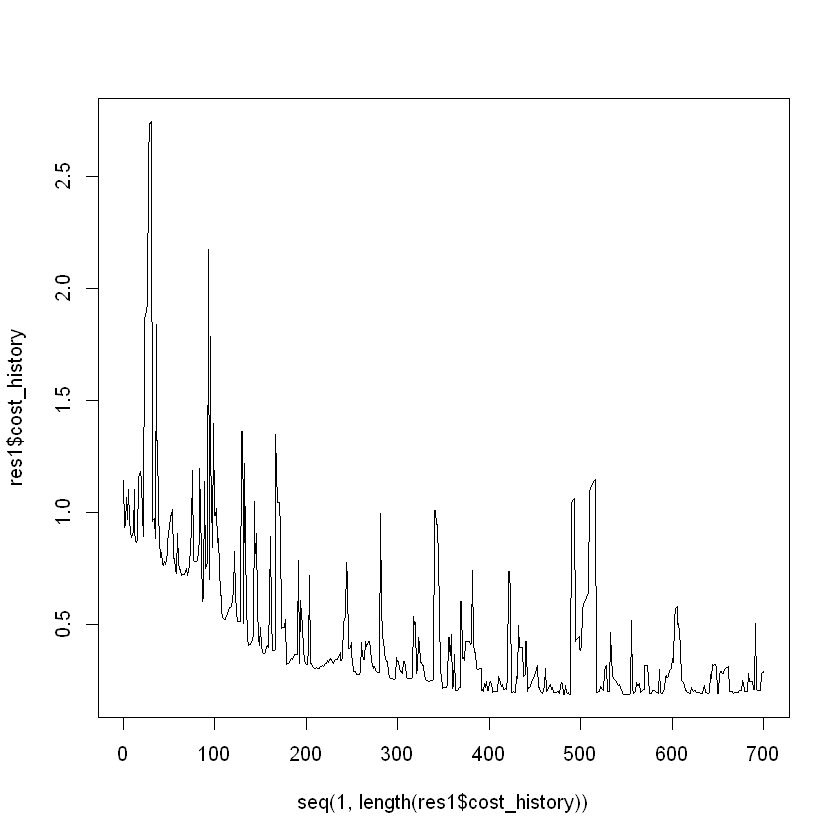

In [260]:
res1 <- fit_bis(classe ~ clump + ucellsize, data, mode = "stochastic", batch_size = 32, learning_rate = 0.1, n_iter = 1)
y_pred <- predict(res1$x, res$theta)
plot(seq(1, length(res1$cost_history)), res1$cost_history, type = "l")

print(res$theta)

accuracy <- mean(y_pred == res$y)
print(accuracy)

                        [,1]
rep.1..length.y.. -6.3852784
clump              0.9659288
ucellsize          0.7716923
[1] 0.9241774


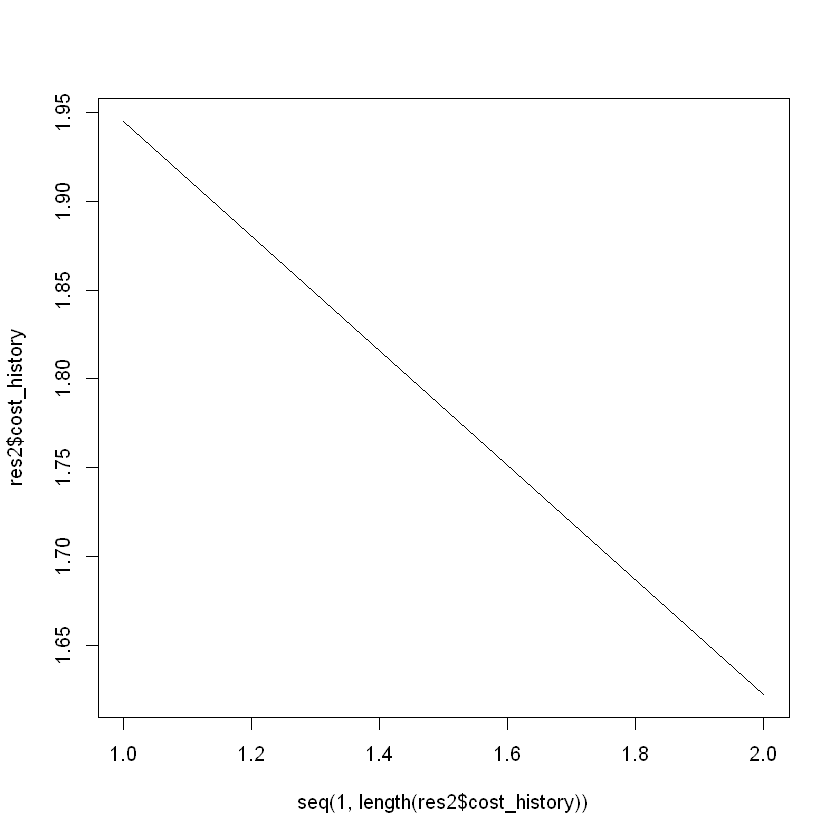

In [262]:
res2 <- fit_bis(classe ~ clump + ucellsize, data, mode = "batch", batch_size = 32, learning_rate = 0.1, n_iter = 1)
y_pred <- predict(res2$x, res$theta)
plot(seq(1, length(res2$cost_history)), res2$cost_history, type = "l")

print(res$theta)

accuracy <- mean(y_pred == res$y)
print(accuracy)

[1] 0.9241774


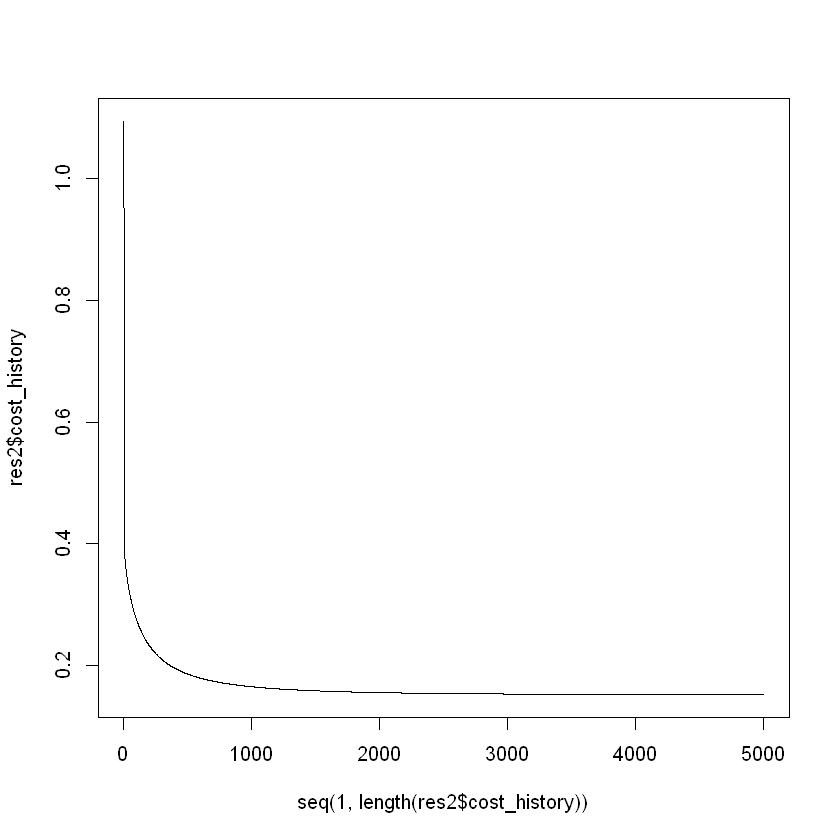